### Runinas para Ingresdo de Sucursales y Datos faltantes
Cocina de Datos

In [ ]:
# RUTINA TRANSFERENCIA DE ARCHIVOS.
import base64
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
# LIBRERIAS NECESARIAS 
from datetime import datetime, timedelta
import numpy as np
from dotenv import dotenv_values
import psycopg2 as pg2    # Conectores para Postgres
import pyodbc  # Conector para SQL Server
import getpass  # Para obtener el usuario del sistema operativo
import uuid  # Importar la librería uuid
# Mostrar el DataFrame resultante
import ace_tools_open as tools

# Evitar Mensajes Molestos
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category= FutureWarning)

secrets = dotenv_values(".env")   # Connection String from .env
folder = secrets["FOLDER_DATOS"]



In [ ]:
# -----------------------------------------------------------
# Funciones de conexión a la base de datos
# -----------------------------------------------------------
def Open_Conn_Postgres():
    secrets = dotenv_values(".env")   # Cargar credenciales desde .env    
    conn_str = f"dbname={secrets['BASE4']} user={secrets['USUARIO4']} password={secrets['CONTRASENA4']} host={secrets['SERVIDOR4']} port={secrets['PUERTO4']}"
    try:    
        conn = pg2.connect(conn_str)
        return conn
    except Exception as e:
        print(f'Error en la conexión: {e}')
        return None

def Open_Connection():
    secrets = dotenv_values(".env")   # Connection String from .env
    conn_str = f'DRIVER={secrets["DRIVER2"]};SERVER={secrets["SERVIDOR2"]};PORT={secrets["PUERTO2"]};DATABASE={secrets["BASE2"]};UID={secrets["USUARIO2"]};PWD={secrets["CONTRASENA2"]}'
    # print (conn_str) 
    try:    
        conn = pyodbc.connect(conn_str)
        return conn
    except:
        print('Error en la Conexión')
        return None

def Close_Connection(conn): 
    conn.close()
    return True

# Helper para generar identificadores únicos
def id_aleatorio():
    return str(uuid.uuid4())

# OTRAS RUTINAS UTILES

def get_excecution_excecute_by_status(status):
    if not status:
        print("No hay estados para filtrar")
        return None
    
    conn = Open_Conn_Postgres()
    if conn is None:
        return None
    try:
        query = f"""
            SELECT 
                a.id, 
                a.description, 
                a.name, 
                a."timestamp", 
                a.supply_forecast_model_id, 
                a.ext_supplier_code, 
                a.graphic, 
                a.monthly_net_margin_in_millions, 
                a.monthly_purchases_in_millions, 
                a.monthly_sales_in_millions, 
                a.sotck_days AS stock_days,  -- Posible corrección
                a.sotck_days_colors AS stock_days_colors, -- Posible corrección
                a.supplier_id, 
                a.supply_forecast_execution_status_id,
                b.supply_forecast_execution_schedule_id AS forecast_execution_schedule_id, 
                b.id AS forecast_execution_execute_id
            FROM public.spl_supply_forecast_execution a
            LEFT JOIN public.spl_supply_forecast_execution_execute b
                ON b.supply_forecast_execution_id = a.id
            WHERE a.supply_forecast_execution_status_id = {status};
        """
        # Ejecutar la consulta SQL
        fexsts = pd.read_sql(query, conn)
        return fexsts
    except Exception as e:
        print(f"Error en get_excecution_status: {e}")
        return None
    finally:
        Close_Connection(conn) 


def get_precios(id_proveedor):
    conn = Open_Connection()
    query = f"""
        SELECT 
        A.[C_PROVEEDOR_PRIMARIO],
        S.[C_ARTICULO]
        ,S.[C_SUCU_EMPR]
        ,S.[I_PRECIO_VTA]
        ,S.[I_COSTO_ESTADISTICO]
        --,S.[M_HABILITADO_SUCU]
        --,A.M_BAJA                   
        FROM [DIARCOP001].[DiarcoP].[dbo].[T051_ARTICULOS_SUCURSAL] S
        LEFT JOIN [DIARCOP001].[DiarcoP].[dbo].[T050_ARTICULOS] A
            ON A.[C_ARTICULO] = S.[C_ARTICULO]
        
        WHERE S.[M_HABILITADO_SUCU] = 'S' -- Permitido Reponer
            AND A.M_BAJA = 'N'  -- Activo en Maestro Artículos
            AND A.[C_PROVEEDOR_PRIMARIO] = {id_proveedor} -- Solo del Proveedor        
        ORDER BY S.[C_ARTICULO],S.[C_SUCU_EMPR];
    """
    # Ejecutar la consulta SQL
    precios = pd.read_sql(query, conn)
    precios['C_PROVEEDOR_PRIMARIO']= precios['C_PROVEEDOR_PRIMARIO'].astype(int)
    precios['C_ARTICULO']= precios['C_ARTICULO'].astype(int)
    precios['C_SUCU_EMPR']= precios['C_SUCU_EMPR'].astype(int)
    return precios


In [ ]:
# EJEMPLO de INSERT Utilizarno FUnciones CRUD con DICT

from datetime import datetime

# Crear diccionario con los datos de la ejecución
data = {
    "end_execution": datetime(2025, 3, 25, 15, 0),
    "last_execution": True,
    "start_execution": datetime(2025, 3, 25, 14, 0),
    "supply_forecast_execution_id": "e53abf0a-789e-44fd-a4e4-89d71587de8b",
    "supply_forecast_execution_schedule_id": "58d7d965-99d6-43b4-a4d4-3732fc0c1f7f",
    "ext_supplier_code": "PROV-0815",
    "graphic": "<svg>...</svg>",
    "monthly_net_margin_in_millions": 5.2,
    "monthly_purchases_in_millions": 48.7,
    "monthly_sales_in_millions": 53.9,
    "sotck_days": 21.3,
    "sotck_days_colors": "verde",
    "supplier_id": "725c8976-7a1b-4cc2-8bce-2450f26ff081",
    "supply_forecast_execution_status_id": 1,
    "contains_breaks": "N",
    "maximum_backorder_days": 3,
    "otif": 95.4,
    "total_products": 48,
    "total_units": 13620.5
}

# Ejecutar función de creación
nuevo_id = create_execution_execute(data)

if nuevo_id:
    print(f"Nuevo registro insertado con ID: {nuevo_id}")
else:
    print("Hubo un error al insertar la ejecución.")

#### SANDBOX para Pruebas Manuales

In [ ]:
id_proveedor = '98'
name= '98_FRATELLI_BRANCA'
forecast_execution_id ='0cd32842-0726-438b-856f-78a67d4c6455'
forecast_execution_excecute_id ='01307697-fcd2-4bcd-af58-474f90cea46d'
supplier_id = '27275183-cf6e-4865-ad33-d1ccd3d32e2e'
algoritmo = '98_FRATELLI_BRANCA_ALGO_01'


df_forecast_ext = pd.read_csv(f'{folder}/{algoritmo}_Pronostico_Extendido.csv')
df_forecast_ext['Codigo_Articulo']= df_forecast_ext['Codigo_Articulo'].astype(int)
df_forecast_ext['Sucursal']= df_forecast_ext['Sucursal'].astype(int)
df_forecast_ext.fillna(0)   # Por si se filtró algún missing value


# Mostrar la tabla con los gráficos en base64

tools.display_dataframe_to_user(name="Forecast Extendido", dataframe=df_forecast_ext)

In [ ]:
print("❗Filas con site_id inválido:", df_forecast_ext['site_id'].isna().sum())
print("❗Filas con product_id inválido:", df_forecast_ext['product_id'].isna().sum())

In [ ]:
def actualizar_site_ids(df_forecast_ext, conn):
    """Reemplaza site_id en df_forecast_ext con datos válidos desde fnd_site"""
    query = """
    SELECT code, name, id FROM public.fnd_site
    WHERE company_id = 'e7498b2e-2669-473f-ab73-e2c8b4dcc585'
    ORDER BY code 
    """
    stores = pd.read_sql(query, conn)
    stores = stores[pd.to_numeric(stores['code'], errors='coerce').notna()].copy()
    stores['code'] = stores['code'].astype(int)

    # Eliminar site_id anterior si ya existía
    df_forecast_ext = df_forecast_ext.drop(columns=['site_id'], errors='ignore')

    # Merge con los stores para obtener site_id
    df_forecast_ext = df_forecast_ext.merge(
        stores[['code', 'id']],
        left_on='Sucursal',
        right_on='code',
        how='left'
    ).rename(columns={'id': 'site_id'})

    # Validar valores faltantes
    missing = df_forecast_ext[df_forecast_ext['site_id'].isna()]
    if not missing.empty:
        print(f"⚠️ Faltan site_id en {len(missing)} registros")
        missing.to_csv(f"{folder}/{name}_Missing_Site_IDs.csv", index=False)
    else:
        print("✅ Todos los registros tienen site_id válido")

    return df_forecast_ext

In [ ]:
conn = Open_Conn_Postgres()
df_forecast_ext = actualizar_site_ids(df_forecast_ext, conn)

In [ ]:
df_forecast_ext_nan = df_forecast_ext[df_forecast_ext['site_id'].isna()]

In [ ]:
fes = get_excecution_excecute_by_status(40)

In [ ]:
df_merged = pd.merge(
    df_forecast_ext,  # DataFrame de artículos
    precio,    # DataFrame de precios
    left_on =['Codigo_Articulo', 'Sucursal'],  # Claves en 'forecast'
    right_on=['C_ARTICULO', 'C_SUCU_EMPR'],  # Claves en 'precios'
    how='left'  # Solo traer los productos que están en 'forecast'
)
df_merged['TOT_VENTA'] = (df_merged['Forecast'] * df_merged['I_PRECIO_VTA'] / 1000).round(2)
df_merged['TOT_COSTO'] = (df_merged['Forecast'] * df_merged['I_COSTO_ESTADISTICO'] / 1000).round(2)
df_merged['MARGEN'] = (df_merged['TOT_VENTA'] - df_merged['TOT_COSTO'] / 1000).round(2)

In [ ]:
# Recuperar Solicitudes de Compra Extended
df_suc_faltantes = pd.read_csv(f'{folder}/Sucursales_Faltantes.csv', delimiter=";", dtype=str)
df_suc_faltantes.columns = df_suc_faltantes.columns.str.strip()  # Elimina espacios adicionales




In [ ]:
# Generar el INSERT dinámicamente
insert_queries = []
for _, row in df_suc_faltantes.iterrows():
    query = f"""
        INSERT INTO public.fnd_site(
            id, address, latitude, longitude, name, "timestamp", type, code, company_id
        ) VALUES (
            gen_random_uuid(), 
            '{row['address']}', 
            {row['latitude'] if row['latitude'] else 'NULL'}, 
            {row['longitude'] if row['longitude'] else 'NULL'}, 
            '{row['name']}', 
            '{row['fecha_hora']}', 
            '{row['type']}', 
            {row['code']}, 
            '{row['company_id']}'
        );
    """
    insert_queries.append(query)

# Guardar los inserts en un archivo SQL para ejecutarlo luego
sql_file_path = f"{folder}/insert_sucursales.sql"
with open(sql_file_path, "w", encoding="utf-8") as file:
    file.writelines("\n".join(insert_queries))

print(f"Archivo SQL generado en: {sql_file_path}")


In [ ]:
import psycopg2

def ejecutar_inserts(sql_file):
    conn = None
    try:
        # Conectar a la base de datos
        conn = Open_Conn_Postgres()
        cur = conn.cursor()

        # Leer el archivo SQL y ejecutarlo
        with open(sql_file, "r", encoding="utf-8") as f:
            sql_script = f.read()
        
        cur.execute(sql_script)
        conn.commit()
        cur.close()
        print("Sucursales insertadas correctamente en la base de datos.")

    except Exception as e:
        print(f"Error ejecutando el insert: {e}")
        if conn:
            conn.rollback()
    finally:
        if conn:
            conn.close()

# Ejecutar los inserts
ejecutar_inserts(sql_file_path)


In [ ]:
# LISTAR PARÄMETROS DE CONFIGURACIÓN del MODELO

query = """"

SELECT  m.method, m.name as detalle, p.name, p.data_type, p.default_value
	FROM public.spl_supply_forecast_model m
	LEFT JOIN public.spl_supply_forecast_model_parameter p
	ON p.supply_forecast_model_id = m.id
	ORDER BY m.method, p.name;

"""

#### FORECAS EXCECUTION PARAMETERS FULL

query = """
SELECT  e.name, m.method, e.ext_supplier_code, 
		p.name, p.data_type, p.default_value, fep.value,
		e.id as supply_forecast_execution_id, p.id as supply_forecast_model_parameter_id, 
		fep.id as supply_forecast_execution_parameter_id
		---, e.description,  e.supply_forecast_model_id,
	FROM public.spl_supply_forecast_execution e
	LEFT JOIN public.spl_supply_forecast_model m
	ON m.id = e.supply_forecast_model_id
	LEFT JOIN public.spl_supply_forecast_model_parameter p
	ON p.supply_forecast_model_id = m.id
	LEFT JOIN public.spl_supply_forecast_execution_parameter fep
	ON fep.supply_forecast_model_parameter_id = p.id

	ORDER BY e.ext_supplier_code, m.method, p.name
"""


# INSERTAR EXCECUTION PARAMETER

query = """
INSERT INTO public.spl_supply_forecast_execution_parameter (
    id, "timestamp", supply_forecast_execution_id, supply_forecast_model_parameter_id, value
)
VALUES
-- d0b0117f
(uuid_generate_v4(), CURRENT_TIMESTAMP, 'cd0c3052-5853-4294-83e5-83ae0cee1407', 'ddfceb28-1a6a-49e6-8230-49e9f2a4313c', 'add'),
(uuid_generate_v4(), CURRENT_TIMESTAMP, 'cd0c3052-5853-4294-83e5-83ae0cee1407', '064efda1-f8b1-46a7-8e14-6971c801b386', 'add')
"""

In [2]:
import math

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle


def plot_colortable(colors, *, ncols=4, sort_colors=True):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig


# ALGORITMOS y sus TIPOS

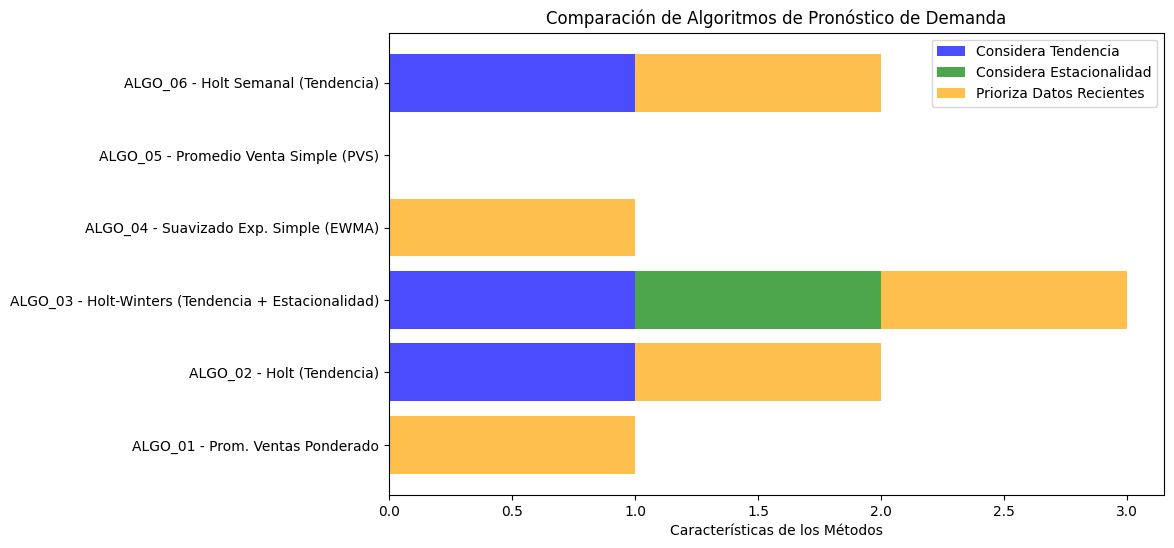

In [1]:
import matplotlib.pyplot as plt

# Definir los métodos y sus características principales
metodos = [
    "ALGO_01 - Prom. Ventas Ponderado",
    "ALGO_02 - Holt (Tendencia)",
    "ALGO_03 - Holt-Winters (Tendencia + Estacionalidad)",
    "ALGO_04 - Suavizado Exp. Simple (EWMA)",
    "ALGO_05 - Promedio Venta Simple (PVS)",
    "ALGO_06 - Holt Semanal (Tendencia)"
]

# Características de cada método (valores ficticios para visualización)
considera_tendencia = [0, 1, 1, 0, 0, 1]  # 1 si considera tendencia, 0 si no
considera_estacionalidad = [0, 0, 1, 0, 0, 0]  # 1 si considera estacionalidad, 0 si no
prioriza_datos_recientes = [1, 1, 1, 1, 0, 1]  # 1 si da más peso a datos recientes, 0 si no

# Crear el gráfico de radar
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(metodos, considera_tendencia, color='blue', alpha=0.7, label="Considera Tendencia")
ax.barh(metodos, considera_estacionalidad, color='green', alpha=0.7, left=considera_tendencia, label="Considera Estacionalidad")
ax.barh(metodos, prioriza_datos_recientes, color='orange', alpha=0.7, left=[sum(x) for x in zip(considera_tendencia, considera_estacionalidad)], label="Prioriza Datos Recientes")

ax.set_xlabel("Características de los Métodos")
ax.set_title("Comparación de Algoritmos de Pronóstico de Demanda")
ax.legend()
plt.show()


# COLORES Y CODIGOS

https://matplotlib.org/stable/gallery/color/named_colors.html


https://patriciaemiguel.com/python/2019/08/01/python-tkinter-colores.html


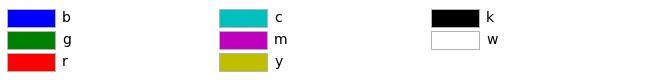

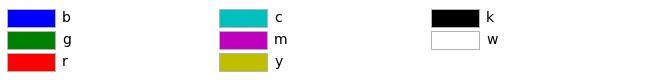

In [3]:
plot_colortable(mcolors.BASE_COLORS, ncols=3, sort_colors=False)

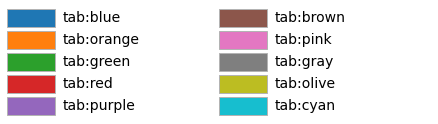

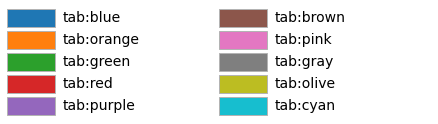

In [4]:
plot_colortable(mcolors.TABLEAU_COLORS, ncols=2, sort_colors=False)

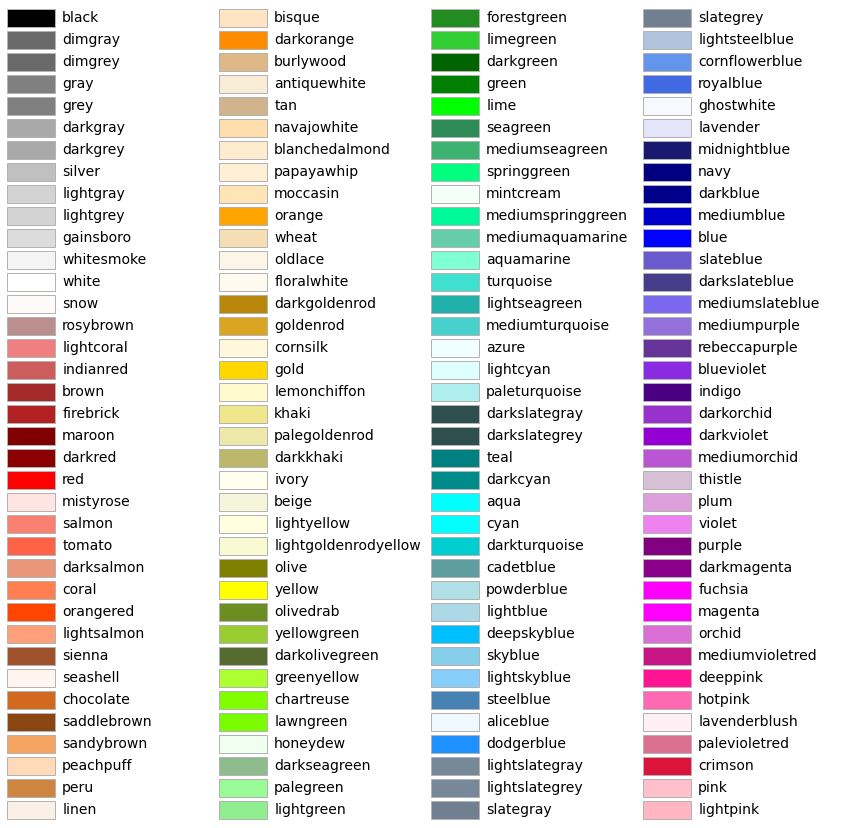

In [5]:
plot_colortable(mcolors.CSS4_COLORS)
plt.show()

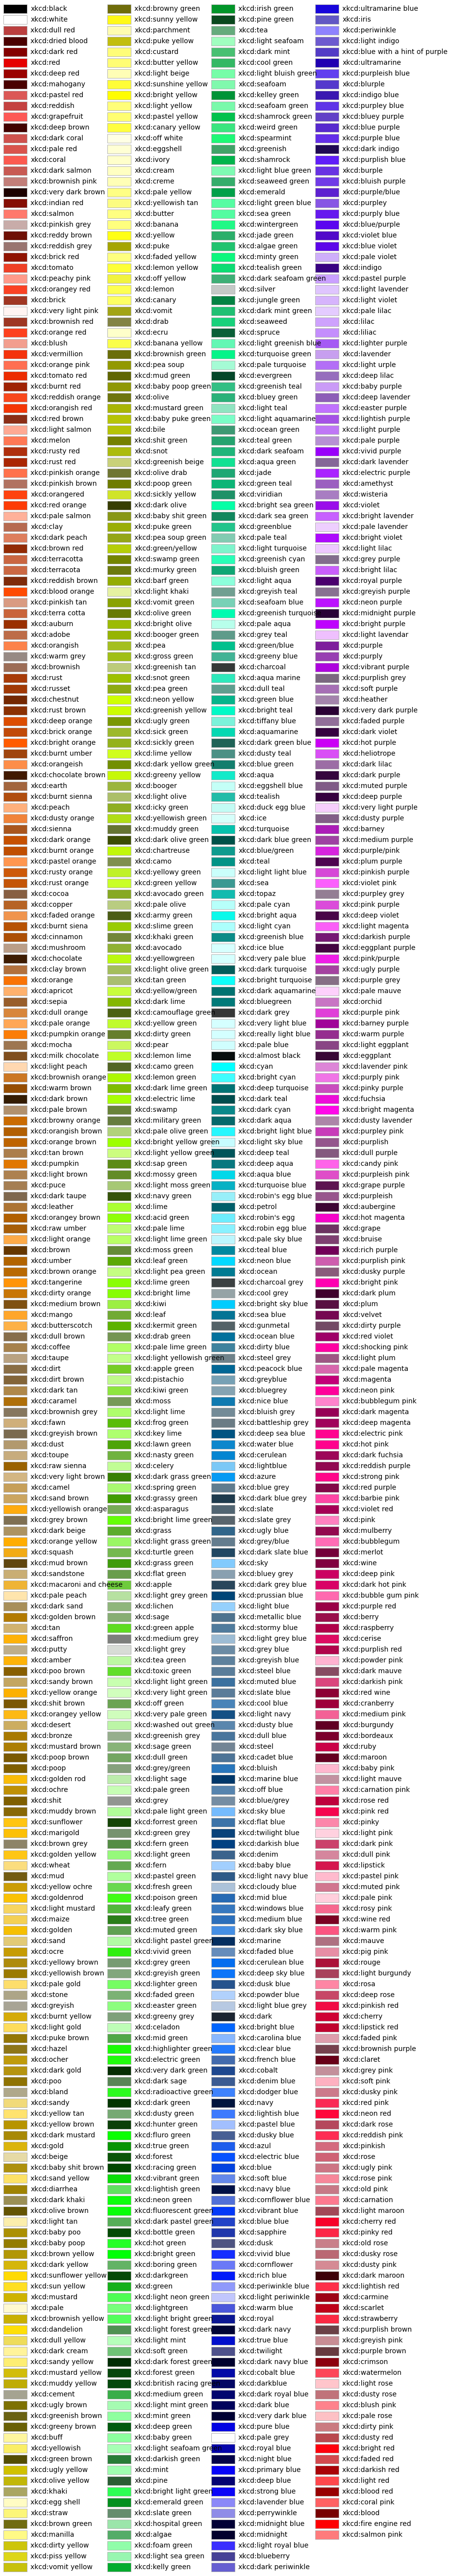

In [6]:
xkcd_fig = plot_colortable(mcolors.XKCD_COLORS)
xkcd_fig.savefig("XKCD_Colors.png")